### Hypothesis testing
___

<br>

#### General setup
___

The Broad Street cholera outbreak investigation that occurred during the 1954 in London.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as ss

%matplotlib inline

<br>

#### Loading the data set
___

In [2]:
# Location of 8 main water pumps in cental London
pumps = pd.read_csv('../Data/pumps.csv')
pumps.head()

,lat,lon,x,y
0,51.513341,-0.136668,0.000000,0.000000
1,51.513876,-0.139586,-0.201858,0.059469
2,51.514906,-0.139671,-0.207738,0.173961
3,51.512354,-0.131630,0.348513,-0.109712
4,51.512139,-0.133594,0.212650,-0.133611


In [3]:
pumps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     8 non-null      float64
 1   lon     8 non-null      float64
 2   x       8 non-null      float64
 3   y       8 non-null      float64
dtypes: float64(4)
memory usage: 384.0 bytes


In [4]:
# Number of deaths in different locations and the closest pump to that location
cholera = pd.read_csv('../Data/cholera.csv')
cholera.head()

,deaths,lat,lon,x,y,closest
0,3,51.513418,-0.137930,-0.087301,0.008559,0
1,2,51.513361,-0.137883,-0.084050,0.002223,0
2,1,51.513317,-0.137853,-0.081975,-0.002668,0
3,1,51.513262,-0.137812,-0.079138,-0.008781,0
4,4,51.513204,-0.137767,-0.076025,-0.015229,0


In [5]:
cholera.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   deaths   250 non-null    int64  
 1   lat      250 non-null    float64
 2   lon      250 non-null    float64
 3   x        250 non-null    float64
 4   y        250 non-null    float64
 5   closest  250 non-null    int64  
dtypes: float64(4), int64(2)
memory usage: 11.8 KB


In [6]:
# Check every 20th record
cholera.loc[0::20]

,deaths,lat,lon,x,y,closest
0,3,51.513418,-0.137930,-0.087301,0.008559,0
20,2,51.513441,-0.138762,-0.144856,0.011116,1
40,2,51.513025,-0.139036,-0.163811,-0.035126,1
60,1,51.512765,-0.137533,-0.059838,-0.064027,0
80,1,51.512782,-0.136819,-0.010446,-0.062137,0
100,4,51.512250,-0.135394,0.088131,-0.121273,5
120,1,51.513238,-0.134594,0.143473,-0.011449,4
140,1,51.512585,-0.134793,0.129707,-0.084035,4
160,1,51.514065,-0.134364,0.159384,0.080478,0
180,1,51.515149,-0.135395,0.088062,0.200973,0


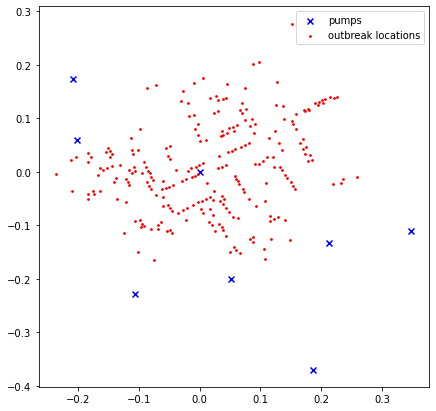

In [7]:
# Plot the both data sets on a square figure
plt.figure(figsize=(7,7))
plt.scatter(pumps.x, pumps.y, color='b', marker='x', label='pumps')
plt.scatter(cholera.x, cholera.y, color='r', s=3, label='outbreak locations')
plt.legend();

In [8]:
# Load the London map
img = matplotlib.image.imread('../Data/london.png')

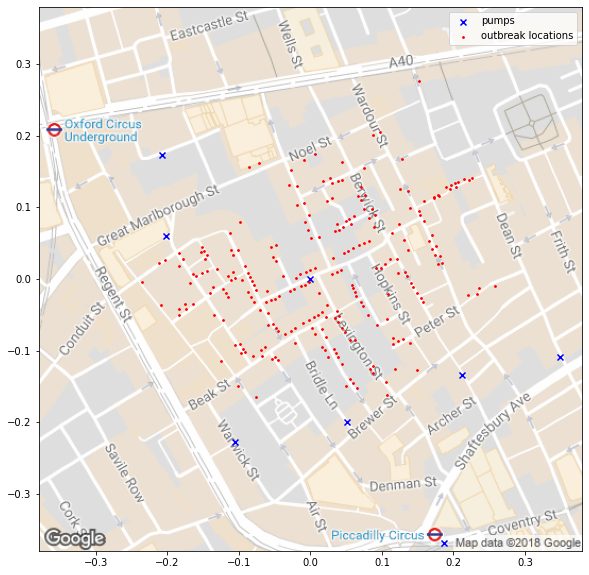

In [9]:
# Overplot the data on the map
plt.figure(figsize=(10,10))
plt.imshow(img, extent=[-0.38,0.38,-0.38,0.38])
plt.scatter(pumps.x, pumps.y, color='b', marker='x', label='pumps')
plt.scatter(cholera.x, cholera.y, color='r', s=3, label='outbreak locations')
plt.legend();

The above map already shows that the main outbreak is around the pump at the center (which is the pump number 0). 

In [10]:
# Let's look at pumps
cholera.closest.value_counts()

0    171
1     36
4     19
5     13
7      9
2      2
Name: closest, dtype: int64

In [11]:
# Total number of deaths closest to each pump
cholera.groupby('closest').deaths.sum()

closest
0    340
1     65
2      5
4     40
5     27
7     12
Name: deaths, dtype: int64

The above shows that the death rate wouldn't be 340 around the pump 0 if the outbreaks were random.

<br>

#### Simulation
___

Let's assume that population of each area is very different with many more people living to the pump 0 (which could explain more deaths there). For simulation we will use the pumps 0, 1, 4, 5 which have the most death cases, and simulate each death randomly proportionally to the population of each area.

In [12]:
def simulate(n):
    """ Function to simulate data for 0,1,4,5 pumps """
    return pd.DataFrame({'closest': np.random.choice([0,1,4,5], size=n, p=[0.65,0.15, 0.1, 0.1])})

In [13]:
# Check the simulated data set
total = cholera.deaths.sum()
simulate(total).head()

,closest
0,1
1,5
2,5
3,0
4,0


In [14]:
# Total number of deaths closest to each pump
simulate(total).closest.value_counts()

0    321
1     78
4     45
5     45
Name: closest, dtype: int64

The figures are close to the actual observed data. Now we need a sampling distribution of the number of deaths in area around the pump 0.

In [15]:
# Extract the count for the pump 0 
pump0 = pd.DataFrame({'counts': [simulate(total).closest.value_counts()[0] for i in range(10000)]})

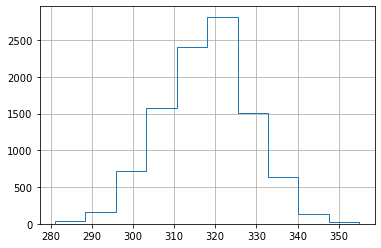

In [16]:
# Check the histogram
pump0.counts.hist(histtype='step');

The above distribution was generated under the null hypothesis that the pumps have nothing to do with cholera and the deaths occur simply proportionally to the population in each area. Now we can compare this distribution with the observed number of 340 deaths in area around the pump 0. More precisely, we evaluate at what quantile we find 340 in this null hypothesis sampling distribution.

In [17]:
# calculate quantile of 340 in the simulated data
ss.percentileofscore(pump0.counts, 340)

98.21

Thus, 340 is an extreme number which we won't expected under the null hypothesis scenario.

In [18]:
print(f'In other words, we can only expect that 340 death under the null scenario to occur in {round(100 - ss.percentileofscore(pump0.counts, 340), 3)}% of the times.')

In other words, we can only expect that 340 death under the null scenario to occur in 1.79% of the times.


The above is known as the p-value and the smaller it is the more strongly we can reject the null hypothesis.

<br>

#### Summary
___

We made an observation that there are many deaths in the area around pump 0 and made a hypothesis that the cause of outbreak was the pump. We then estimated the distribution of the expected deaths under the null hypothesis. Last, we verified how extreme our obsered finding was with the respect to the null distribution.

<br>

___
#### End